In [2]:
import pandas as pd
import pyodbc
import time

conn = pyodbc.connect("Driver={SQL Server};Server=LAMVT1FINTECH\SQL2019;Database=StackOverflow2013;Trusted_Connection=yes;")
query = f"""
    SELECT Id AS UserId, DisplayName, Location FROM dbo.Users WHERE Location = '{'Helsinki, Finland'}'
"""
df_user = pd.read_sql(query, conn)

query = f"""
    SELECT UserId, Id, Score, Text, CreationDate FROM dbo.Comments
    WHERE CreationDate BETWEEN '{'2013-08-01'}' AND '{'2013-08-30'}'
"""
start = time.time()
df_comment = pd.read_sql_query(query, conn)
df_user.set_index('UserId')
df_comment.set_index('UserId')
df_result = pd.merge(df_user, df_comment, on='UserId').sort_values(by='Score', ascending=False)
end = time.time()
print(end - start)


130.8617765903473


In [4]:
#print(df_result[df_result['Id']==27140701])
print(df_result['UserId'])


130    1478655
122     351716
62       56285
59       56285
160     365237
        ...   
339     995876
341     995876
342     995876
343     995876
885    2095090
Name: UserId, Length: 886, dtype: int64


In [10]:
df_result.to_csv("D:\\Repo\\Personal\\Github\\DevOps\\Python\\rs.csv"
                 , columns=["DisplayName", "UserId", "Id", "Score", "Text"]
                 , index=False
                 , encoding="utf-8")

In [55]:
from sqlalchemy import create_engine
engine = create_engine(
    'postgresql://postgres:Hh010898@@@localhost:5432/stackoverflow')

with engine.connect() as psql_conn:
    df1 = pd.read_sql_query(
        'select * from users limit 100', psql_conn)

print(df1)


Empty DataFrame
Columns: [index, id, aboutme, age, creationdate, displayname, downvotes, emailhash, lastaccessdate, location, reputation, upvotes, views, websiteurl, accountid]
Index: []


In [60]:
from io import StringIO 
import csv

s_buf = StringIO()
df_result.to_csv(s_buf
                , header=True
                , columns=["DisplayName", "UserId", "Id", "Score", "Text"]
                 , index=False
                 , encoding="utf-8")
s_buf.seek(0)

copy_query = "COPY user_test FROM STDOUT csv DELIMITER ',' NULL ''  ESCAPE '\\' HEADER "  # Replace your table name in place of mem_info
psql_conn = engine.raw_connection()
cur = psql_conn.cursor()
cur.copy_expert(copy_query, s_buf)
psql_conn.commit()


In [99]:
def psql_insert_copy(table, conn, keys, data_iter):
    # gets a DBAPI connection that can provide a cursor
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf)
        writer.writerows(data_iter)
        s_buf.seek(0)
        print(keys)
        
        columns = ', '.join('"{}"'.format(k) for k in keys)
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name)
        else:
            table_name = table.name

        sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(
            table_name, columns)
        print(sql)
        cur.copy_expert(sql=sql, file=s_buf)


df_result.rename(columns= {'Id':'CommentId'}, inplace=True)
df_result.to_sql('user03', engine, method=psql_insert_copy, if_exists = 'replace', index=False)

['UserId', 'DisplayName', 'Location', 'CommentId', 'Score', 'Text', 'CreationDate']
COPY user03 ("UserId", "DisplayName", "Location", "CommentId", "Score", "Text", "CreationDate") FROM STDIN WITH CSV


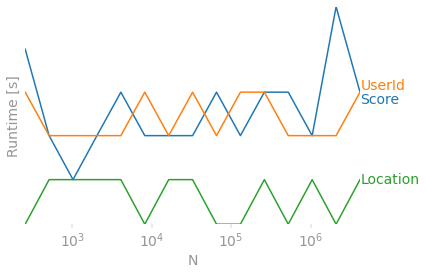

In [7]:
import perfplot

def make_data(n):
    df1 = df_result['Score']
    df2 = df_result['UserId']
    df3 = df_result['Location']

    return df1, df2, df3

perfplot.show(
    setup=lambda n: make_data(n),
    kernels=[
        lambda dfs: dfs[0].loc[100],
        lambda dfs: dfs[1].loc[100],        
        lambda dfs: dfs[2].loc[100],
    ],
    labels=['Score', 'UserId', 'Location'],
    n_range=[2 ** k for k in range(8, 23)],
    xlabel='N',
    logx=True,
    logy=True,
    equality_check=False)